In [1]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from collections import Counter

# Allow python to import modules from the preprocessing folder
sys.path.append("src/preprocessing/")

from load_dataset import *

SAVE_PATH = "./data/refined"
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

# Table of contents
Given the multiple sources of data and the various steps required to set up our future analysis, this notebook is relatively large. To make assessment of our work easier, we provide a table of contents with dynamic links for your convenience. 

## [Part 0: Requirements](#part_0_title)

### &emsp; [Download data](#part_0_download_data)

## [Part I: Load, explore and join movie datasets](#part_1_title)

### &emsp; [CMU dataset](#part_1_cmu)

#### &emsp; &emsp; [CMU characters](#part_1_cmu_characters)
#### &emsp; &emsp; [CMU movies](#part_1_cmu_movies)
#### &emsp; &emsp; [CMU plots](#part_1_cmu_plots)
#### &emsp; &emsp; [CMU tropes](#part_1_cmu_tropes)

### &emsp; [IMDb dataset](#part_1_imdb)

#### &emsp; &emsp; [IMDb ratings](#part_1_imdb_ratings)
#### &emsp; &emsp; [IMDb titles](#part_1_imdb_title)
#### &emsp; &emsp; [IMDb principals](#part_1_imdb_principals)
#### &emsp; &emsp; [IMDb people](#part_1_imdb_people)

### &emsp; [Joining titles with ratings](#part_1_imdb_title_with_ratings)

### &emsp; [Joining CMU movies & plots with IMDb titles & ratings](#part_1_cmu_movies_joined_imdb_title_with_ratings)

### &emsp; [Joining IMDb people with IMDb principals](#part_1_imdb_people_with_principals)

### &emsp; [Filtering CMU characters](#part_1_cmu_filter_characters)

### &emsp; [Joining CMU characters with IMDb people & principals](#part_1_imdb_actors_characters_with_cmu_characters)

### &emsp; [Part I summary](#part_1_summary)

#### &emsp; &emsp; [Saving](#part_1_saving)

## [Part 2: Character tropes / Personas](#part_2_title)

### &emsp; [TVTropes personas](#part_2_tv_tropes_personas)

#### &emsp; &emsp; [Analyse tropes characters](#part_2_tv_tropes_per_actor)
#### &emsp; &emsp; [Introduction of the preference metric](#part_2_preference_metric)
#### &emsp; &emsp; [Joining TVTropes with movies](#part_2_tvtropes_joined_movies)

### &emsp; [Joining original paper tropes with actors & characters](#part_2_cmu_personas_joined_character)

## [Part 3: Movie based comfort zones](#part_3_movie_based_comfort_zones)

### &emsp; [Based on genre](#part_3_movie_based_comfort_zones_genre)
### &emsp; [Based on runtime](#part_3_movie_based_comfort_zones_runtime)

<hr style="height:2px;border:none;color:#333;background-color:#333;">

# Part 0: Requirements <a name="part_0_title"></a>

## Download data <a name="part_0_download_data"></a>

In order to download all required datasets, run the cell bellow (may take a while the first time).

In [8]:
%run src/preprocessing/download_dataset.py

[x] Fail to register archieve format .gz (make sure requirements.txt are satisfied)
.gz is already registered for "gz"
[+] Found cached dataset for url https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz
[+] Found cached dataset for url https://datasets.imdbws.com/title.basics.tsv.gz
[+] Found cached dataset for url https://datasets.imdbws.com/name.basics.tsv.gz
[+] Found cached dataset for url https://datasets.imdbws.com/title.ratings.tsv.gz
[+] Found cached dataset for url https://datasets.imdbws.com/title.principals.tsv.gz
[+] Found cached dataset for url https://raw.githubusercontent.com/MichelDucartier/ACL_personas_dump/master/personas/25.100.lda.cond.log.txt.gz
[+] Found cached dataset for url https://raw.githubusercontent.com/MichelDucartier/ACL_personas_dump/master/personas/25.100.lda.log.txt.gz
[+] Found cached dataset for url https://raw.githubusercontent.com/MichelDucartier/ACL_personas_dump/master/personas/featureFile.txt.gz
[+] Found cached dataset for url http

# Part I: Load, explore and join movie datasets <a name="part_1_title"></a>

## CMU dataset <a name="part_1_cmu"></a>

We load the 4 `.tsv` and `.txt` files of the CMU dataset into 4 different dataframes

In [9]:
characters_df = load_characters_df()
movies_df = load_movies_df()
plot_df = load_plot_df()
tvtropes_df = load_tvtropes_df()

### Characters <a name="part_1_cmu_characters"></a>

The characters dataframe comes from the CMU movies dataset. This dataframe describes movie characters and provides information about the actor who played the corresponding character. Here is a sample of this dataframe :

In [10]:
characters_df.sample(5)

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
243625,33832193,/m/0hnf785,1972-04-13,NaN,1946-06-05,F,NaN,/m/0222qb,Stefania Sandrelli,25.0,/m/0hnzxpb,NaN,/m/0cv0r5
258334,239009,/m/01jntj,1955-08-03,H.H. Hughson,1903-04-15,M,1.87,NaN,John Williams,52.0,/m/0k75sg,/m/0h5tw5k,/m/01k3_r
392982,29227405,/m/0cs040z,1966,Guard,NaN,M,NaN,NaN,Ratan Gaurang,NaN,/m/0h6n4jp,/m/0h6n4jr,/m/0gdkfr0
435326,32340262,/m/0bv_bc_,1992,NaN,NaN,NaN,NaN,NaN,Antonio Neiwiller,NaN,/m/0bv_bg6,NaN,/m/0bv_bg2
237893,13861985,/m/03cljvq,2007-12-12,J-Jizzy,1959-07-12,M,1.85,/m/0x67,Charlie Murphy,48.0,/m/04m7n0h,/m/0h2qdtt,/m/02x1hg


In [11]:
total_characters = len(characters_df)
print(f"Number of characters loaded: {total_characters}")
print(f"Number of unique movies: {len(characters_df['wiki_movie_id'].unique())}")
print(f"Number of unique actors: {len(characters_df['freebase_actor_id'].unique())}", end="\n\n")

print(f"Percentage of missing gender: {characters_df['actor_gender'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing height: {characters_df['actor_height'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing ethnicity: {characters_df['actor_ethnicity'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing age upon release: {characters_df['release_actor_age'].isna().sum()/total_characters*100:.2f}%", end="\n\n")

print(f"Number of character records for which ethnicity is known: {len(characters_df[~characters_df['actor_ethnicity'].isna()])}")
print(f"Number of unique actors for which ethnicity is known: {len(characters_df[~characters_df['actor_ethnicity'].isna()]['freebase_actor_id'].unique())}")

Number of characters loaded: 450669
Number of unique movies: 64330
Number of unique actors: 135761

Percentage of missing gender: 10.12%
Percentage of missing height: 65.65%
Percentage of missing ethnicity: 76.47%
Percentage of missing age upon release: 35.08%

Number of character records for which ethnicity is known: 106058
Number of unique actors for which ethnicity is known: 8151


We can first notice that a great percentage of actor's ethnicity is missing. This may become a problem when we study the impact of actors' ethnicity on the success of a movie. Let's investigate a bit.

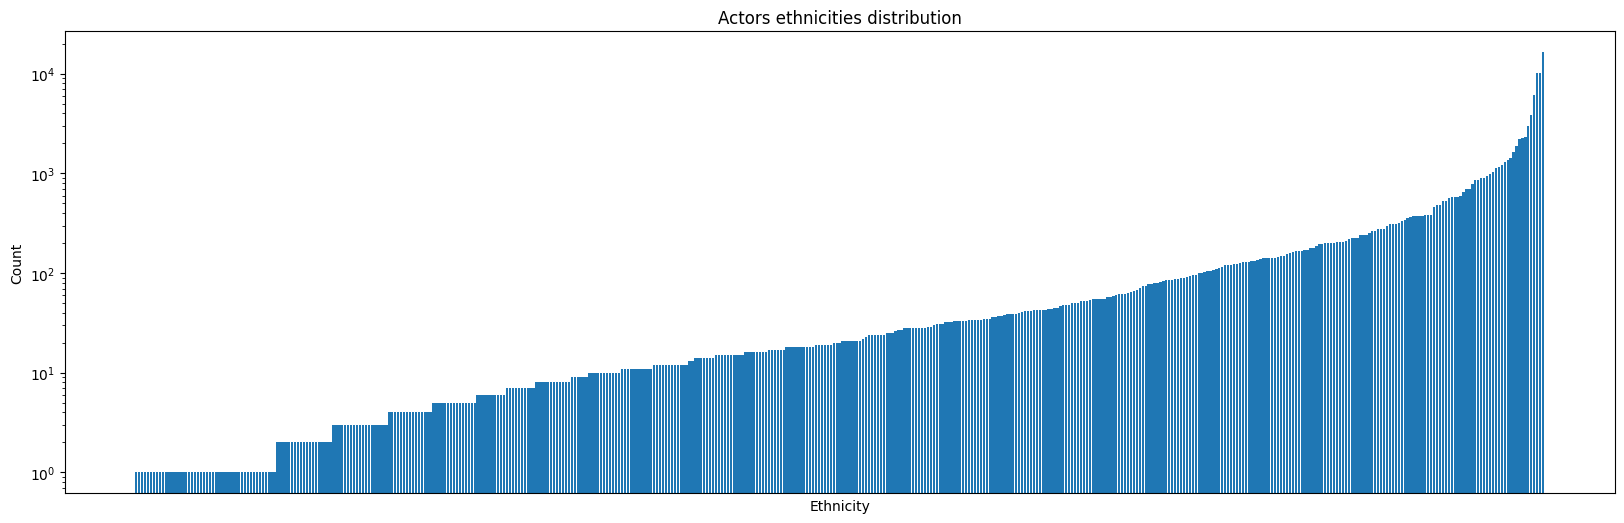

In [12]:
actors_ethnicities = characters_df[['freebase_actor_id', 'actor_ethnicity']].dropna().groupby(by='actor_ethnicity').count()
actors_ethnicities = actors_ethnicities.sort_values(by='freebase_actor_id')

plt.figure(figsize=(20,6))
plt.bar(actors_ethnicities.index, actors_ethnicities['freebase_actor_id'], label='')
plt.title("Actors ethnicities distribution")
plt.yscale('log')
plt.xticks([])
plt.ylabel("Count")
plt.xlabel("Ethnicity")
plt.show()

As shown, the ethnicities distribution is very heterogeneous. Some ethnicities have only one representative whereas others have more than thousands elements. During analysis, we must be careful on our conclusions as variance gets higher for the ethnicities with fewer representatives. Fortunately, we can quantify uncertainty in our results using tools like p-value and confidence interval.

### Movies <a name="part_1_cmu_movies"></a>

The movies dataframe also comes from the CMU dataset and provides information about movies such as its origins, runtime and box office.

In [13]:
movies_df.sample(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office,movie_runtime,movie_languages,movie_countries,movie_genres
19119,15933397,/m/03qhfnv,Guilty Hearts,2005-11-05,NaN,93.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/068d7h': 'Romantic drama', '/m/02l7c8': '..."
38159,26865246,/m/0bmjd8w,The Flying Fox in the Snowy Mountains,NaN,NaN,NaN,{},{},{'/m/04t2t': 'Martial Arts Film'}
11820,5079388,/m/0d1rq1,Subconscious Cruelty,2000-10-12,NaN,92.0,{'/m/02h40lc': 'English Language'},{'/m/0d060g': 'Canada'},"{'/m/03npn': 'Horror', '/m/0219x_': 'Indie'}"
16819,12945105,/m/02z0yqq,Please Experience Wolfmother Live,2007,NaN,71.0,{},{'/m/09c7w0': 'United States of America'},"{'/m/04rlf': 'Music', '/m/0d2rhq': 'Concert fi..."
4359,27995999,/m/0ch1_pm,Girl Walks into a Bar,2011-03-07,NaN,80.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/07s9rl0': 'Drama', '/m/01hmnh': 'Fantasy'..."


In [14]:
total_movies = len(movies_df)
print(f"Number of movies loaded: {total_movies}")
print(f"Percentage of missing box office revenue: {movies_df['box_office'].isna().sum()/total_movies*100:.2f}%")
print(f"Number of movies for which we have matching character data: {len(movies_df.merge(characters_df, how='inner', on=['wiki_movie_id', 'freebase_movie_id'])['freebase_movie_id'].unique())}")

Number of movies loaded: 81741
Percentage of missing box office revenue: 89.72%
Number of movies for which we have matching character data: 64330


A great proportion of box office revenue data is missing (almost 90%). This makes sense as lots of movies are not shown in cinemas such as TV movies, short movies. Indeed, to get a movie to the box office, one needs to work with studios or convince distributors to distribute the movie.

Thus, using box office as a way to measure a movie's performance may be biased because we already filter a specific type of movie. Furthermore, box office does not necessarily reflect the quality of a movie. Indeed some movies may not get a high box office revenue because of a lack of advertising. To fix this issue, we will use users rating from the IMDb database.

In [15]:
# Extract years from the release date of movies
movies_df['movie_release_year'] = movies_df[~movies_df['movie_release_date'].isna()]['movie_release_date'].astype(str).str[:4].astype(int)

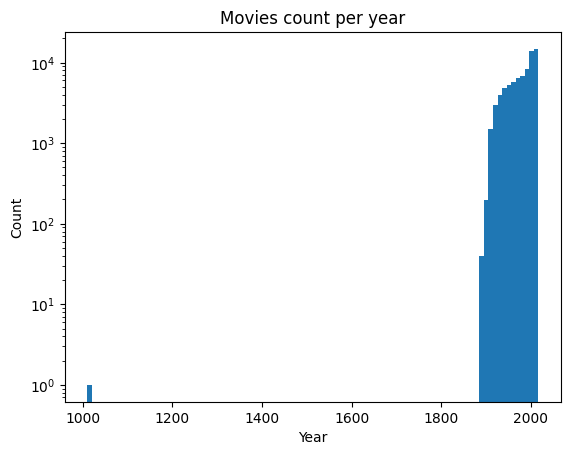

In [16]:
plt.hist(movies_df['movie_release_year'], bins=100)
plt.yscale("log")
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Movies count per year")
plt.show()

We notice that a movie has been produced 700 years before the invention of potography ! Let's investigate:

In [17]:
wrong_dates = movies_df[movies_df['movie_release_year'] < 1800].index
movies_df.loc[wrong_dates]

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year
62836,29666067,/m/0fphzrf,Hunting Season,1010-12-02,12160978.0,140.0,"{'/m/02hwyss': 'Turkish Language', '/m/02h40lc...",{'/m/01znc_': 'Turkey'},"{'/m/0lsxr': 'Crime Fiction', '/m/02n4kr': 'My...",1010.0


By googling the movie's name, we find that `Hunting season` should be released in 2010 (instead of 1010). This is obviously a typo and 1010 should be replaced by 2010.

In [18]:
# A movie that has the release date 1010. We fix the typo to 2010
movies_df.loc[wrong_dates, 'movie_release_year']= 2010
movies_df.loc[wrong_dates, 'movie_release_date'] ='2010-12-02'

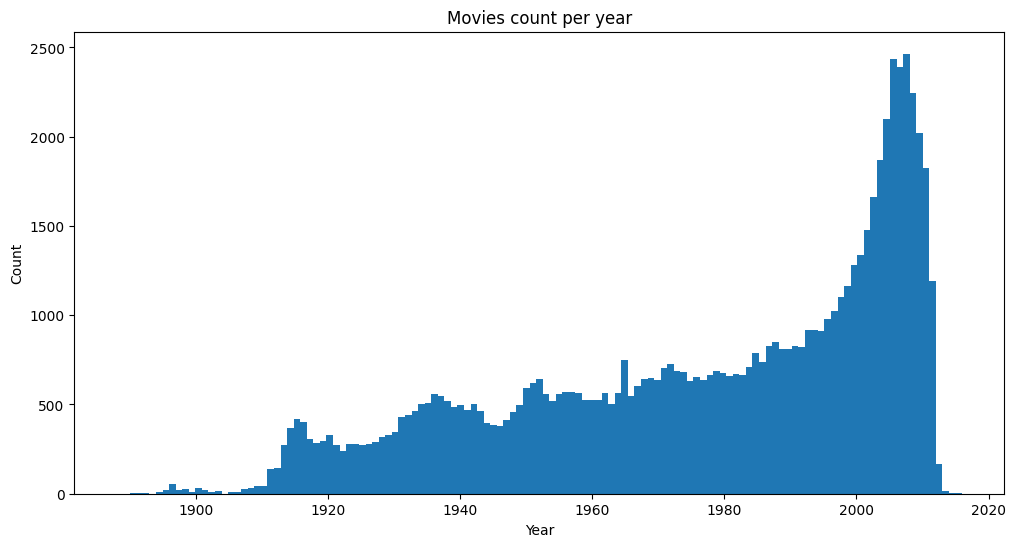

In [19]:
n_years = len(movies_df['movie_release_year'].dropna().unique())

plt.figure(figsize=(12, 6))
plt.hist(movies_df['movie_release_year'], bins=n_years)
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Movies count per year")
plt.show()

There are significantly more movies released after 1990 than before in our dataset.

### Plots <a name="part_1_cmu_plots"></a>

The plot dataframe comes from the CMU dataset and provides a summary of the plot of a given movie.

In [20]:
plot_df.sample(5)

,wiki_movie_id,plot_summary
29964,16686744,"Julian Marsh , an unemployed young lothario, i..."
8140,3326435,With the exception of the opening and final sc...
30698,711102,"Lucas Bly is an extremely intelligent, but ne..."
18340,15672850,Pearl is as an ambitious hoyden who rises from...
32184,6372126,Moments after the end of Class of Nuke 'Em Hig...


In [21]:
total_plot = len(plot_df)
print(f"Number of plot summaries loaded: {total_plot}")

Number of plot summaries loaded: 42303


### Tropes <a name="part_1_cmu_tropes"></a>

The tvtropes dataframe is the one used by the CMU researchers to validate their personas learning algorithm. Unfortunately, this dataset does not contain a lot of tvtropes and can not be used for our analysis. Thus we need other databases to get the persona of movie characters.

In [22]:
tvtropes_df.sample(5)

,trope_name,character_data
257,final_girl,"{'char': 'Nancy Thompson', 'movie': 'A Nightma..."
412,romantic_runnerup,"{'char': 'Lon Hammond Jr.', 'movie': 'The Note..."
425,slacker,"{'char': 'Kumar Patel', 'movie': 'Harold & Kum..."
113,corrupt_corporate_executive,"{'char': 'Doctor Doom', 'movie': 'Fantastic Fo..."
22,big_man_on_campus,"{'char': 'Paul Metzler', 'movie': 'Election', ..."


In [23]:
total_tropes = len(tvtropes_df)
print(f"Number of tropes loaded: {total_tropes}")

Number of tropes loaded: 501


## IMDB dataset <a name="part_1_imdb"></a>

We need to define a metric of "success" of a film. Even if we are already provided with the `box_office` column in the cmu dataset, it only includes data for the bigger blockbusters, wihch represent only 10% of the movies. We have therefore decided to use the imdb rating of the film as a metric defining its performance.

We also used the `people` and `principals` collections from IMDb to enrich the `characters` collection from the CMU corpus, reducing the amount of missing information.

We load the 4 `.tsv` files of the IMDB dataset into 4 different dataframes

In [24]:
imdb_ratings_df = load_imdb_ratings()
imdb_title_df = load_imdb_title_basics()
imdb_principals_df = load_imdb_title_principals()
imdb_people_df = load_imdb_person_basics()

In [25]:
imdb_principals_df.sample(5)

,tconst,ordering,nconst,category,job,characters
54100679,tt8209892,1,nm4213931,actress,\N,"[""Paulina Navarette""]"
26071287,tt1639682,5,nm0088392,writer,written by,\N
58144834,tt9605512,2,nm0127925,actor,\N,"[""Renzo Figueroa"",""Mateo Mónaco""]"
54807964,tt8457036,10,nm7137252,editor,\N,\N
7630292,tt10061650,2,nm10551566,director,\N,\N


### Ratings <a name="part_1_imdb_ratings"></a>

In [26]:
imdb_ratings_df.sample(5)

,tconst,averageRating,numVotes
1247457,tt6970184,8.6,214
693487,tt14684390,7.4,16
1026720,tt3326052,7.1,102
1004976,tt3001698,7.7,7
154404,tt0249909,8.2,13


We have 1368573 movies for which we have a rating.


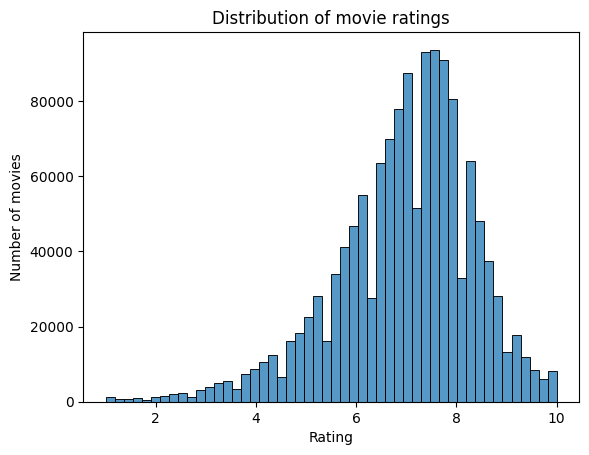

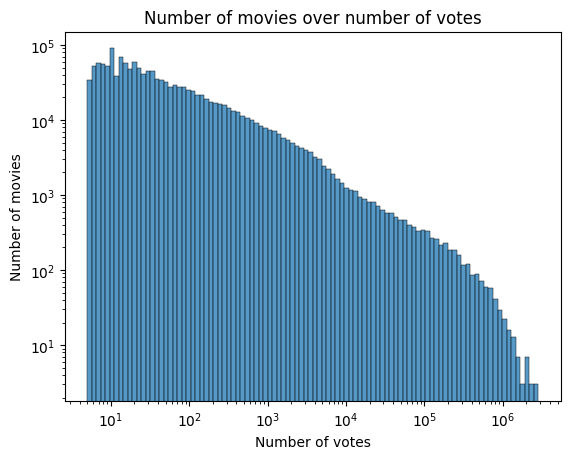

In [27]:
total_ratings = len(imdb_ratings_df)
print(f"We have {total_ratings} movies for which we have a rating.")

# Check the distribution of grades
sns.histplot(data=imdb_ratings_df, x="averageRating", bins=50)

plt.title("Distribution of movie ratings")
plt.xlabel("Rating")
plt.ylabel("Number of movies")
plt.show()

# Check the distribution of votes
sns.histplot(data=imdb_ratings_df, x="numVotes", bins=100, log_scale=True)
plt.yscale("log")

plt.title("Number of movies over number of votes")
plt.xlabel("Number of votes")
plt.ylabel("Number of movies")
plt.show()

### Titles <a name="part_1_imdb_title"></a>

In [28]:
imdb_title_df.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
7401811,tt3445858,movie,Red Raccoon,Red Raccoon,0,\N,\N,98,"[Comedy, Horror]"
6693153,tt27916539,movie,Most Wanted Nazis,Most Wanted Nazis,0,2023,\N,53,[Documentary]
4140234,tt1581829,movie,Windfall,Windfall,0,2010,\N,81,"[Documentary, Drama]"
2464471,tt12723806,movie,The Class That Saved Coach K,The Class That Saved Coach K,0,2019,\N,90,"[Documentary, Sport]"
3122983,tt13944150,movie,Love Incidental,Love Incidental,0,2021,\N,78,"[Comedy, Drama, Romance]"


In [29]:
# Remove adult content
imdb_title_df = imdb_title_df[imdb_title_df["isAdult"].astype(int) == 0]
total_title = len(imdb_title_df)
print(f"We have {total_title} movie titles")

We have 652869 movie titles


### Principals <a name="part_1_imdb_principals"></a>

In [30]:
total_principals = len(imdb_principals_df)
print(f"We have {total_principals} principals records")
print(f"We have {len(imdb_principals_df['category'].unique())} categories")
print(f"We have {len(imdb_principals_df['nconst'].unique())} unique persons", end="\n\n")

imdb_principals_df.sample(5)

We have 59057327 principals records
We have 12 categories
We have 5179687 unique persons



,tconst,ordering,nconst,category,job,characters
42716739,tt3519328,2,nm5296932,actress,\N,"[""Leslie""]"
27427669,tt1750168,6,nm1391467,director,\N,\N
6736510,tt0903193,8,nm0293388,producer,producer,\N
11189702,tt11100314,2,nm10641661,actor,\N,\N
39447597,tt28357537,7,nm14238715,production_designer,\N,\N


### People <a name="part_1_imdb_people"></a>

In [31]:
total_people = len(imdb_people_df)
print(f"We have {total_people} people records")
print(f"We have {len(imdb_people_df['nconst'].unique())} unique persons")
print(f"We have {len(imdb_people_df[(imdb_people_df['primaryProfession'] == 'actor') | (imdb_people_df['primaryProfession'] == 'actress')])} unique actors")

imdb_people_df.sample(5)

We have 13007226 people records
We have 13007226 unique persons
We have 0 unique actors


,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
5196249,nm14595879,Pati Cruz,\N,\N,[editorial_department],[tt11840016]
2437862,nm11599348,Behnam Shahabi,\N,\N,[camera_department],[tt2206088]
11159185,nm7704412,Kimberly Curtis,\N,\N,[make_up_department],"[tt4625046, tt5159216]"
12037261,nm8813561,Marcelo Gonzalez,\N,\N,[actor],[tt6582964]
9974566,nm6148023,Lauren M. Sherman,\N,\N,"[miscellaneous, actress]","[tt5049642, tt2203939, tt3514324, tt2015381]"


## Merge IMDb movie titles with IMDb ratings <a name="part_1_imdb_title_with_ratings"></a>

In [32]:
imdb_title_with_rating = imdb_title_df.merge(imdb_ratings_df, on='tconst', how='inner')

total_movies_w_rating = len(imdb_title_with_rating)
print(f"We have {total_movies_w_rating} movies with ratings")

imdb_title_with_rating.sample(5)

We have 295284 movies with ratings


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
43652,tt0080711,movie,Fade to Black,Fade to Black,0,1980,\N,102,"[Comedy, Crime, Horror]",6.1,4863
57258,tt0104710,movie,Leon the Pig Farmer,Leon the Pig Farmer,0,1992,\N,104,"[Comedy, Crime]",5.7,567
2606,tt0016559,movie,Zakroyshchik iz Torzhka,Zakroyshchik iz Torzhka,0,1925,\N,65,[Comedy],6.9,155
103676,tt0282599,movie,Il Mare,Siworae,0,2000,\N,105,"[Drama, Fantasy, Romance]",7.5,9315
23356,tt0049974,movie,The Young Guns,The Young Guns,0,1956,\N,84,[Western],5.6,140


There is more than one quarter of a million movies for which we have at least one rating. We have clearly much more data to work with than with box office revenue. Furthermore, there is a substantial amount of movies who have at least a few hundreds votes. This will allow us to get better confidence interval and reduce uncertainty in our analysis.

## Merge CMU movies and plot summaries with IMDB titles and ratings <a name="part_1_cmu_movies_joined_imdb_title_with_ratings"></a>

The translation dataframe from wikidata, which includes both the IMDB id and the Freebase id, enables us to combine the IMDB dataset with the CMU dataset

In [33]:
translation_id = load_translation_df()

imdb_title_with_rating_translated = imdb_title_with_rating.merge(translation_id, how='inner', left_on='tconst', right_on='imdb_id').copy()
imdb_title_with_rating_translated = imdb_title_with_rating_translated.drop(["imdb_id"], axis=1)

cmu_movies_w_imdb_rating = imdb_title_with_rating_translated.merge(movies_df, how='inner', left_on='freebase_id', right_on='freebase_movie_id').copy()

# Enriching CMU data
# IMDB start year has no missing data, so we insert it into "NaN" fields of "movie_release_date" and drop "startYear"
missing_years = cmu_movies_w_imdb_rating[cmu_movies_w_imdb_rating['movie_release_date'].isna()].index
cmu_movies_w_imdb_rating.loc[missing_years, 'movie_release_date'] = cmu_movies_w_imdb_rating.loc[missing_years, 'startYear']

# We have MANY depulicated attributes
# We evaluated for each pair which column had more missing data and dropped it in favor of the other
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.drop(["freebase_movie_id", "titleType", "isAdult", "endYear", "primaryTitle", "originalTitle", "movie_release_year", "movie_runtime", "startYear"], axis=1)

cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.drop_duplicates("tconst")
print(f"The merged dataframe contains {len(cmu_movies_w_imdb_rating)} movies with corresponding ratings")

The merged dataframe contains 44476 movies with corresponding ratings


In [34]:
# Add summaries
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.merge(plot_df, on="wiki_movie_id", how="left")
cmu_movies_w_imdb_rating.sample(5)

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
6638,tt0038776,128,"[Biography, Drama, Musical]",6.1,3088,/m/0g0y8m,6321252,Night and Day,1946,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/04t36': 'Musical', '/m/017fp': 'Biography...",NaN
11660,tt0054315,63,"[Action, War]",4.0,586,/m/09gf32b,25079696,Ski Troop Attack,1963,NaN,{},{'/m/09c7w0': 'United States of America'},"{'/m/03btsm8': 'Action/Adventure', '/m/0hj3mz0...",A group of ski troopers behind German lines du...
17353,tt0074888,82,"[Drama, Romance]",7.2,1604,/m/02wvpd8,12554600,The Best Way to Walk,1976,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/07s9rl0': 'Drama', '/m/01z4y': 'Comedy', ...",Marc and Philippe are two teenage summer-camp ...
30882,tt0246952,120,"[Documentary, Sport]",7.7,26,/m/03c4kf7,13414238,A Step Away,1980,NaN,"{'/m/02h40lc': 'English Language', '/m/06nm1':...","{'/m/09c7w0': 'United States of America', '/m/...",{'/m/0jtdp': 'Documentary'},NaN
37071,tt0482606,86,"[Horror, Mystery, Thriller]",6.1,140312,/m/02prw2f,9776644,The Strangers,2008-05-29,82344798.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/03npn': 'Horror'...",{{Plot}} The movie starts with a recorded 911 ...


## Merge IMDb people and IMDb principals <a name="part_1_imdb_people_with_principals"></a>
We now focus on characters and actors. We merge the two dataframes from IMDB and keep records of interest i.e for which the movie is in the collection above.

In [35]:
titles_of_interest = set(cmu_movies_w_imdb_rating["tconst"].to_list())

imdb_people_not_nan = imdb_people_df[imdb_people_df["primaryProfession"].notna()]

imdb_actors = imdb_people_not_nan[imdb_people_not_nan["primaryProfession"].apply(lambda l : ("actor" in l) or ("actress" in l))].copy()
imdb_principals_actors = imdb_principals_df[(imdb_principals_df["category"] == "actress") | (imdb_principals_df["category"] == "actor")].copy()

imdb_actors_and_characters = imdb_actors.merge(imdb_principals_actors, on="nconst", how="inner").copy()
imdb_actors_and_characters = imdb_actors_and_characters[imdb_actors_and_characters["tconst"].isin(titles_of_interest)]
imdb_actors_and_characters = imdb_actors_and_characters.drop(["ordering", "category", "job", "primaryProfession"], axis=1)

In [36]:
imdb_actors_and_characters.sample(5)

,nconst,primaryName,birthYear,deathYear,knownForTitles,tconst,characters
2574651,nm0182765,Pilar L. Cotta,\N,\N,"[tt0007627, tt0007888, tt0008613, tt0008662]",tt0008662,"[""Lupita Flores""]"
2243813,nm0150718,Marge Champion,1919,2020,"[tt0044030, tt0048719, tt0063415, tt0045822]",tt0044855,"[""Clarisse""]"
6786792,nm0639613,Joan O'Brien,1936,\N,"[tt0053580, tt0057765, tt0057191, tt0053143]",tt0056110,"[""Wanda Paxton""]"
8972554,nm0930326,Cynda Williams,1966,\N,"[tt0106148, tt12580116, tt0102592, tt0100168]",tt0107319,"[""Rebecca""]"
6257305,nm0581103,Mario Merola,1934,2006,"[tt0082637, tt0082139, tt0078995, tt0081663]",tt0123025,"[""Michele Barresi""]"


## Filter CMU characters <a name="part_1_cmu_filter_characters"></a>
We keep records of interest in the same fashion as done above

In [37]:
titles_of_interest_wiki = cmu_movies_w_imdb_rating["wiki_movie_id"].to_list()
characters_interest = characters_df[characters_df["wiki_movie_id"].isin(titles_of_interest_wiki)]
characters_interest.sample(5)

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
125200,2853134,/m/086yk3,1985,NaN,1954-05-25,M,NaN,/m/04mvp8,Murali,30.0,/m/03lc9wc,NaN,/m/02qy3py
383934,90156,/m/0mf0h,1988,NaN,1953-06-22,F,1.61,NaN,Cyndi Lauper,34.0,/m/025dn10,NaN,/m/01wf86y
63692,29075630,/m/0bpm4yw,2012-07-16,John Blake,1981-02-17,M,1.78,/m/013b6_,Joseph Gordon-Levitt,31.0,/m/0gm6cw8,/m/0gwh6mh,/m/05zbm4
241363,4728198,/m/0ckbnz,1997-09-03,Monsieur LePluche,NaN,M,NaN,NaN,Jacques Disses,NaN,/m/0cg_mld,/m/0cg_mlh,/m/0cg_mlq
38319,5464664,/m/0dn17z,1941-05-30,NaN,1901-02-09,M,1.73,NaN,Brian Donlevy,40.0,/m/04y_0k4,NaN,/m/03kd1c


## Merge IMDb actors and characters with CMU characters <a name="part_1_imdb_actors_characters_with_cmu_characters"></a>

We merge IMDB character and actor data with the CMU data. We make use of the movie translation dataframe again and the actor translation dataframe. We assume that an actor only plays one role in a movie. This is not necessarily true as some actors may play many roles in the same movie, but we assume that those cases are sufficiently rare so that we can ignore them.

In [38]:
# Actor translation dataframe
actor_translation_df = load_actors_translation_df()
actor_translation_df = actor_translation_df.rename(columns={'imdb_id' : 'actor_imdb_id', 'freebase_id' : 'actor_freebase_id'})

In [39]:
imdb_actors_and_characters_translated = imdb_actors_and_characters.merge(translation_id, how='inner', left_on='tconst', right_on='imdb_id').copy()
imdb_actors_and_characters_translated = imdb_actors_and_characters_translated.merge(actor_translation_df, how='inner', left_on='nconst', right_on='actor_imdb_id')
imdb_actors_and_characters_translated = imdb_actors_and_characters_translated.drop(["imdb_id", "actor_imdb_id"], axis=1)

In [40]:
imdb_actors_w_cmu_characters = imdb_actors_and_characters_translated.merge(characters_interest, how='right', left_on=['freebase_id', 'actor_freebase_id'], right_on=['freebase_movie_id', 'freebase_actor_id']).copy()

In [41]:
# Merge birth year information
missing_birth_years = imdb_actors_w_cmu_characters[imdb_actors_w_cmu_characters['actor_birth'].isna()].index
imdb_actors_w_cmu_characters.loc[missing_birth_years, 'actor_birth'] = imdb_actors_w_cmu_characters.loc[missing_birth_years, 'birthYear']

# Merge character information
def get_first_characters(ls):
    if isinstance(ls, float) | (ls == "\\N"):
        return np.nan
    return ls.split('"')[1]
imdb_actors_w_cmu_characters["characters"] = imdb_actors_w_cmu_characters["characters"].apply(get_first_characters)
missing_characters = imdb_actors_w_cmu_characters[imdb_actors_w_cmu_characters['character_name'].isna()].index
imdb_actors_w_cmu_characters.loc[missing_characters, 'character_name'] = imdb_actors_w_cmu_characters.loc[missing_characters, 'characters']

imdb_actors_w_cmu_characters = imdb_actors_w_cmu_characters.drop(["freebase_id", "actor_freebase_id", "primaryName", "deathYear", "birthYear", "knownForTitles", "nconst", "tconst", "characters"], axis=1)

imdb_actors_w_cmu_characters = imdb_actors_w_cmu_characters.drop_duplicates(subset="freebase_map_id")

imdb_actors_w_cmu_characters = imdb_actors_w_cmu_characters.rename(columns={'freebase_movie_id' : 'freebase_id'})

imdb_actors_w_cmu_characters.head(5)

,wiki_movie_id,freebase_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


## Summary of results for part I <a name="part_1_summary"></a>
We now have two main dataframes for further analysis. One containing everything related to movies and their ratings and the other containing everything related to actors, their features and characters they played in a given movie.

In [42]:
movies = cmu_movies_w_imdb_rating.copy()
actors_characters = imdb_actors_w_cmu_characters.copy()
movies.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
0,tt0000009,45,[Romance],5.3,207,/m/02q23xk,10109752,Miss Jerry,1894-10-09,NaN,{'/m/06ppq': 'Silent film'},{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",After finding out that her father is suffering...
1,tt0000147,100,"[Documentary, News, Sport]",5.3,484,/m/0czdh_n,28703057,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,{},{},{'/m/01z02hx': 'Sports'},The film no longer exists in its entirety; how...
2,tt0000574,70,"[Action, Adventure, Biography]",6.0,855,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,{'/m/02h40lc': 'English Language'},{'/m/0chghy': 'Australia'},"{'/m/0lsxr': 'Crime Fiction', '/m/06ppq': 'Sil...",The Story of the Kelly Gangs tone is of sorrow...
3,tt0000591,90,[Drama],5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",NaN
4,tt0000679,120,"[Adventure, Fantasy]",5.1,68,/m/0fgfyy,5954041,The Fairylogue and Radio-Plays,1908-09-24,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06ppq': 'Silent film', '/m/01g6gs': 'Blac...",NaN


In [43]:
actors_characters.head()

,wiki_movie_id,freebase_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


### Saving <a name="part_1_saving"></a>

In [44]:
movies.to_json(os.path.join(SAVE_PATH, "movies.json"), orient='records')

In [45]:
actors_characters.to_json(os.path.join(SAVE_PATH, "characters.json"), orient='records')

# Part II: Character tropes / Personas <a name="part_2_title"></a>

In [2]:
# Load results of part I
movies = pd.read_json(os.path.join(SAVE_PATH, "movies.json"))
actors_characters = pd.read_json(os.path.join(SAVE_PATH, "characters.json"))

## TVTropes personas <a name="part_2_tv_tropes_personas"></a>
We now load the 500 personas records we extracted from TVTropes

In [3]:
tvtropes_personas = load_tv_tropes_personas_df()
tvtropes_personas.head()

,id,trope,actor,character,movie_name
0,/m/02wszk9,chanteuse,Kathleen Turner,Jessica Rabbit,Who Framed Roger Rabbit
1,/m/0k5wls,chanteuse,Cameron Diaz,Tina Carlyle,The Mask
2,/m/0k50tl,chanteuse,Michelle Pfeiffer,Susie Diamond,The Fabulous Baker Boys
3,/m/0k3j8v,chanteuse,Marilyn Monroe,Sugar Kane Kowalczyk,Some Like It Hot
4,/m/0jvlc4,chanteuse,Isabella Rossellini,Dorothy Vallens,Blue Velvet


### Analyse tropes per actor <a name="part_2_tv_tropes_per_actor"></a>
Let's see if actors have diverse tropes

In [4]:
tvtropes_per_actor = tvtropes_personas[["actor", "trope"]].copy().groupby("actor").agg(list).reset_index()
tvtropes_per_actor["num_tropes"] = tvtropes_per_actor["trope"].apply(lambda ls: len(list(dict.fromkeys(ls))))
tvtropes_per_actor = tvtropes_per_actor.sort_values("num_tropes", ascending = False)
tvtropes_per_actor.head()

,actor,trope,num_tropes
166,Johnny Depp,"[casanova, charmer, byronic_hero, byronic_hero...",7
279,Robert De Niro,"[crazy_jealous_guy, crazy_jealous_guy, tranqui...",6
109,Harrison Ford,"[charmer, bounty_hunter, loveable_rogue, trick...",6
57,Clint Eastwood,"[retired_outlaw, heartbroken_badass, bounty_hu...",6
64,Daniel Craig,"[cultured_badass, heartbroken_badass, charmer,...",5


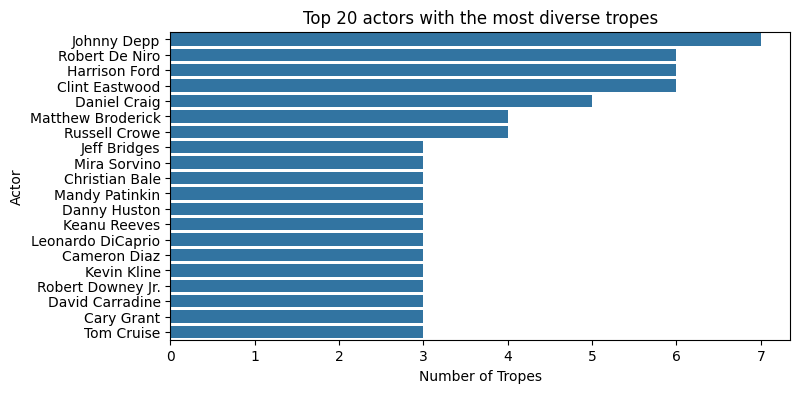

In [67]:
plt.figure(figsize=(8, 4))
sns.barplot(data = tvtropes_per_actor.head(20), x="num_tropes", y="actor", orient='h')
plt.xlabel('Number of Tropes')
plt.ylabel('Actor')
plt.title('Top 20 actors with the most diverse tropes')
plt.show()

As we can see we have a problem. We only have very few well known actors with multiple personas. This makes further analysis impossible, but we use this very high quality dataset to introduce our metrics

### Preference Metric <a name="part_2_preference_metric"></a>

As describe in the [`README.md`](./README.md#methods), we need a **preference metric** per actor. This metric should measure the tendency for a given actor $A$ to have a preferred trope (or set of tropes). A naïve approach would be to compare the distribution of a given actor $A$ to the uniform distribution of tropes. However a rapid analysis show us that the global tropes distribution is not uniform (and as such a more meaningful metric should be determined).



A more meaningfull metric need to be extracted

- **Cross Entropy based metric**:
    
    $$f(\text{Actor}) = \frac{ H(\text{Persona}) }{ H(\text{Persona} | \text{Actor})}$$
    
    This metric has the following property
    - If the actor $A$ always plays the same persona, then $f(A) = +\infty$
    - If the actor $A$ plays each persona randomly (same distribution than the global distribution), then $f(A) = 1$

In [286]:
# Implementation of the cross entropy per actors
tvtropes_per_actor_filtered = tvtropes_per_actor[tvtropes_per_actor["num_tropes"] > 3].copy()
tvtropes_per_actor_filtered

def compute_entropy(array_like):
    array_like = list(array_like)
    dic = {}
    for elem in array_like:
        dic[elem] = dic.get(elem, 0) + 1
    occurences = np.array(list(dic.values()))
    probabilities = occurences / np.sum(occurences)
    return -np.dot(np.log2(probabilities), probabilities)

H_global = compute_entropy(tvtropes_per_actor_filtered['trope'].sum())

tvtropes_per_actor_filtered['cross_entropy_based'] = H_global / tvtropes_per_actor_filtered['trope'].apply(compute_entropy)
tvtropes_per_actor_filtered.head()

,actor,trope,num_tropes,cross_entropy_based
166,Johnny Depp,"[casanova, charmer, byronic_hero, byronic_hero...",7,1.598494
279,Robert De Niro,"[crazy_jealous_guy, crazy_jealous_guy, tranqui...",6,1.756055
109,Harrison Ford,"[charmer, bounty_hunter, loveable_rogue, trick...",6,1.827315
57,Clint Eastwood,"[retired_outlaw, heartbroken_badass, bounty_hu...",6,1.743254
64,Daniel Craig,"[cultured_badass, heartbroken_badass, charmer,...",5,1.893194


- **Mutual Information**:

    $$f(\text{Actor}) = \frac{I(\text{Persona}, \text{Actor})}{H(\text{Persona})} = \frac{ H(\text{Persona}) - H(\text{Persona} | \text{Actor}) }{H(\text{Persona})}$$

    This metric has the following property
    - If the actor $A$ always plays the same persona, then $f(A) = 1$
    - If the actor $A$ plays each persona randomly (same distribution than the global distribution), then $f(A) = 0$

In [287]:
tvtropes_per_actor_filtered['mutual_information_based'] = (H_global - tvtropes_per_actor_filtered['trope'].apply(compute_entropy)) / H_global
tvtropes_per_actor_filtered.head()

,actor,trope,num_tropes,cross_entropy_based,mutual_information_based
166,Johnny Depp,"[casanova, charmer, byronic_hero, byronic_hero...",7,1.598494,0.374411
279,Robert De Niro,"[crazy_jealous_guy, crazy_jealous_guy, tranqui...",6,1.756055,0.430542
109,Harrison Ford,"[charmer, bounty_hunter, loveable_rogue, trick...",6,1.827315,0.452749
57,Clint Eastwood,"[retired_outlaw, heartbroken_badass, bounty_hu...",6,1.743254,0.426360
64,Daniel Craig,"[cultured_badass, heartbroken_badass, charmer,...",5,1.893194,0.471792


### Analyse frequency of tropes when joined with our movies <a name="part_2_tvtropes_joined_movies"></a>
Get an idea of the distribution of personas.

In [288]:
tvtropes_personas_std = tvtropes_personas.copy()
tvtropes_personas_std['movie_name_standardized'] = tvtropes_personas_std['movie_name'].str.lower()

movies_std = movies.copy()
movies_std['movie_name_standardized'] = movies_std['movie_name'].str.lower()

movies_personas = movies_std.merge(tvtropes_personas_std, on='movie_name_standardized', how='inner')

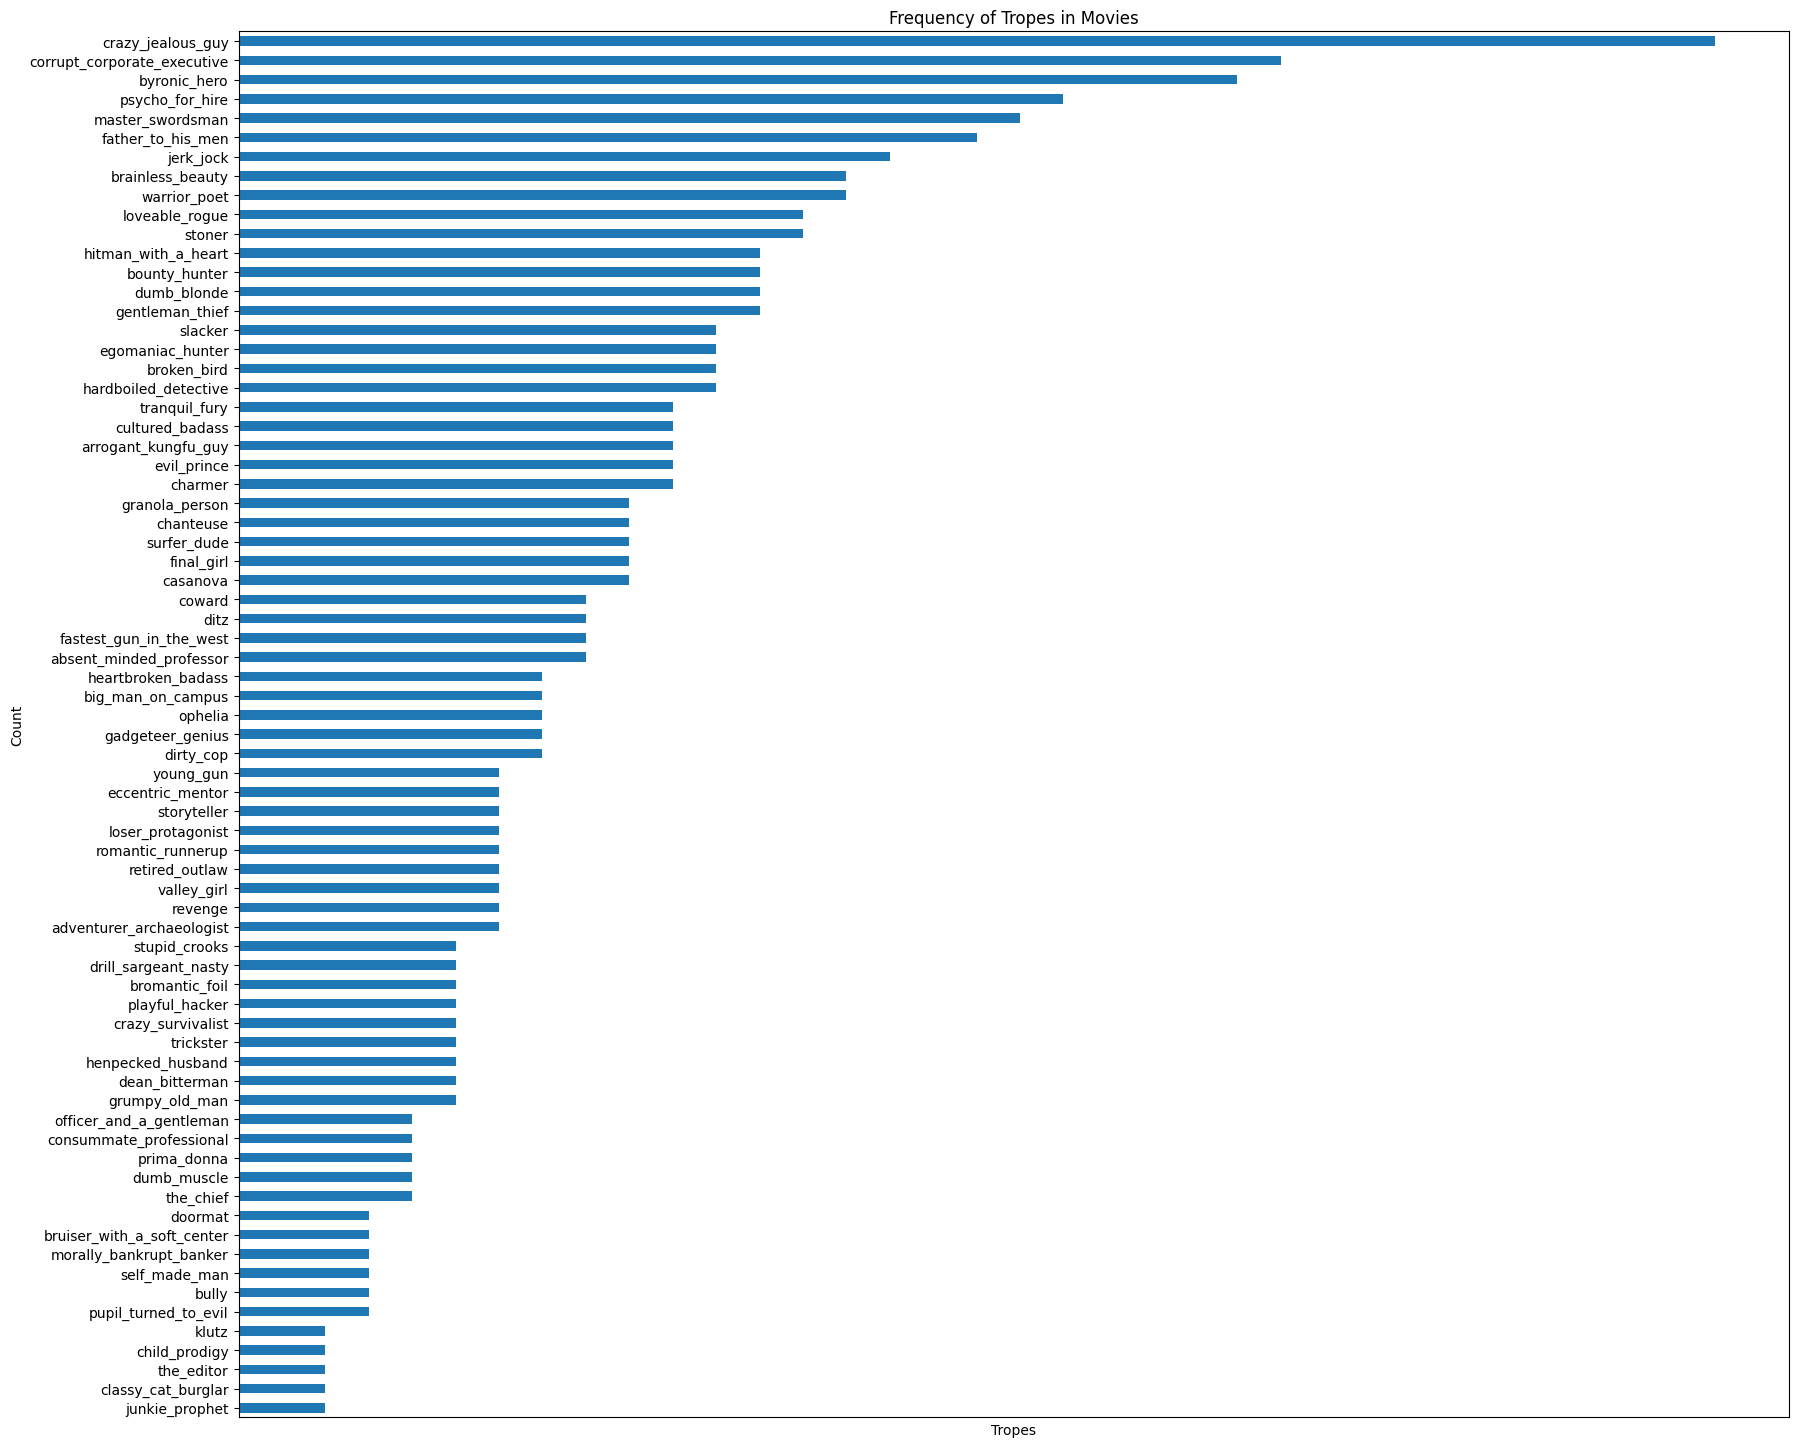

In [289]:
trope_value_counts = movies_personas['trope'].value_counts()

plt.figure(figsize=(20, 18))
trope_value_counts.plot(kind='barh', xticks=[])
plt.xlabel('Count')
plt.ylabel('Tropes')
plt.title('Frequency of Tropes in Movies')
plt.gca().invert_yaxis()
plt.show()

## CMU tropes with actors & characters <a name="part_2_cmu_personas_joined_character"></a>

We merge the actors and characters information we extracted in part I with the tropes from the original paper

In [78]:
cmu_personas = load_personas()
cmu_personas.sample(5)

,freebase_id,wiki_id,movie_name,secondary_name,full_name,token_occurences,estimated_trope,trope_distrib
6092,/m/0jt6pk,1091346,Alfie,Alfie Cartwright,his,39,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
99927,e3,29852202,The Flying Doctor,Vaughan,Vaughan,5,23,"[0.0, 0.0, 0.01, 0.24, 0.0, 0.0, 0.0, 0.0, 0.0..."
33275,e14,1597802,I'll Sleep When I'm Dead,he,he,15,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
34543,e16,1619604,Marooned,President,The President,3,9,"[0.0, 0.03, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0, 0.0..."
24019,e0,14069401,Jail Bait,he,he,5,46,"[0.0, 0.0, 0.02, 0.0, 0.0, 0.02, 0.01, 0.0, 0...."


In [79]:
cmu_personas = cmu_personas.drop(columns=['secondary_name', 'full_name'])
cmu_personas = cmu_personas.rename(columns={'freebase_id' : 'freebase_map_id'})
movies_personas_cmu = cmu_personas.merge(actors_characters, on='freebase_map_id')

In [82]:
print(f"We have {len(movies_personas_cmu)} records for characters and their corresponding trope")

We have 31025 records for characters and their corresponding trope


This offers us one possiblity for further analysis, as we have more than 30'000 records

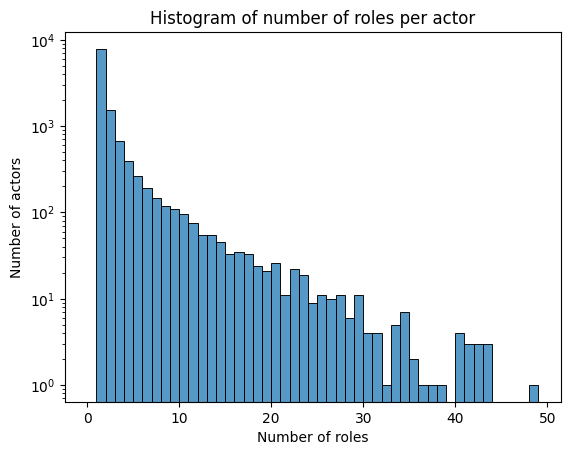

In [83]:
characters_per_actor = movies_personas_cmu[['freebase_actor_id', 'freebase_map_id']].groupby(by='freebase_actor_id').count()
sns.histplot(data=characters_per_actor, x='freebase_map_id', bins=range(50))
plt.yscale('log')
plt.xlabel("Number of roles")
plt.ylabel("Number of actors")
plt.title("Histogram of number of roles per actor")
plt.show()

In [10]:
print(f"Number of actors with 5 roles or more : {len(characters_per_actor[characters_per_actor['freebase_map_id'] >= 5])}")
print(f"Number of actors with less than 5 roles : {len(characters_per_actor[characters_per_actor['freebase_map_id'] < 5])}")

Number of actors with 5 roles or more : 1481
Number of actors with less than 5 roles : 10447


With 5 roles or more, we consider that we can decide "with some confidence" if an actor has a preferred persona or not (under this threshold, data may not be significant enough). There is a reasonable proportion of actors for which we gathered enough roles to be confident in our analysis (roughly 20% of the original number of actors). 

Nevertheless, in further methods, we may decide to only keep actors with a number of roles greater than some threshold (to be confident in our metric computations). This may become a source of bias as there is more chance that an actor is successful if he plays in more movies (thus our analysis may become relevant only for "successful" actors and not for actors in general). 

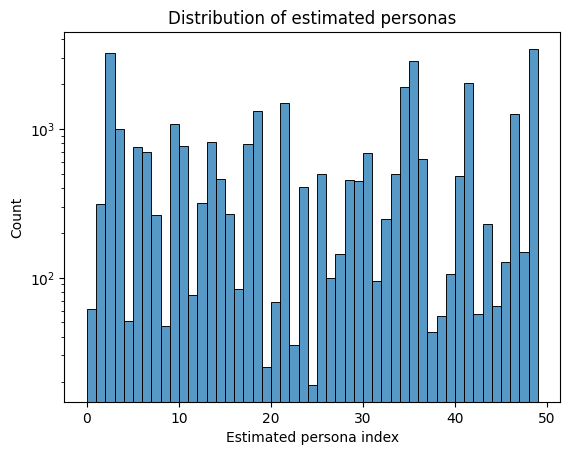

In [11]:
sns.histplot(data=movies_personas_cmu, x='estimated_trope', bins=range(50))
plt.yscale("log")
plt.xlabel('Estimated persona index')
plt.ylabel('Count')
plt.title('Distribution of estimated personas')
plt.show()

The distribution of estimated personas is very heterogeneous, some personas only have one representative ! This can lead to very high variance. For instance suppose for those personas that their representative (movie role) is in a very good movie (according to our movies' success evaluation), then we will deduce that this persona always lead to very good rating and will bias our analysis. We hope that this issue can be mitigated with uncertainty estimation.

Because of all of those possible limitations, to be even more confident with our result, we introduce another way to determine an actor's comfort zone which is based on the movies' genres.

# Part III: Movie-based comfort zones <a name="part_3_movie_based_comfort_zones"></a>

We investigate the possiblity of coming up with comfort zones by analysing movie features for a given actor instead of personas. Defining an actor's comfort zone as such seems at first glance like a reasonable approach. Indeed, even when an actor embodies diverse characters, if they still plays for the same type of movies this would raise questions about whether they are truly venturing beyond their comfort zone. Whereas with totally different genres (such as Sport and Action/Adventure movies for instance), we would be more confident that the difference is significant enough to make a difference for the critics.

However this is a much more coarse-grained analysis as differences in actors' tropes may still be really noticeable even for similar genres.

In [68]:
movies.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
0,tt0000009,45,[Romance],5.3,207,/m/02q23xk,10109752,Miss Jerry,1894-10-09,NaN,{'/m/06ppq': 'Silent film'},{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",After finding out that her father is suffering...
1,tt0000147,100,"[Documentary, News, Sport]",5.3,484,/m/0czdh_n,28703057,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,{},{},{'/m/01z02hx': 'Sports'},The film no longer exists in its entirety; how...
2,tt0000574,70,"[Action, Adventure, Biography]",6.0,855,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,{'/m/02h40lc': 'English Language'},{'/m/0chghy': 'Australia'},"{'/m/0lsxr': 'Crime Fiction', '/m/06ppq': 'Sil...",The Story of the Kelly Gangs tone is of sorrow...
3,tt0000591,90,[Drama],5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",None
4,tt0000679,120,"[Adventure, Fantasy]",5.1,68,/m/0fgfyy,5954041,The Fairylogue and Radio-Plays,1908-09-24,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06ppq': 'Silent film', '/m/01g6gs': 'Blac...",None


In [69]:
actors_characters.head()

,wiki_movie_id,freebase_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,None,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,None,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,None,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [14]:
all_data = movies.merge(actors_characters, how="inner", on=["freebase_id", "wiki_movie_id"])
all_data.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,...,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,tt0000147,100,"[Documentary, News, Sport]",5.3,484,/m/0czdh_n,28703057,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,...,None,1866-09-01,M,NaN,None,James J. Corbett,NaN,/m/0gvztx7,None,/m/037fcq
1,tt0000574,70,"[Action, Adventure, Biography]",6.0,855,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,...,None,None,None,NaN,None,Mr. Marshall,NaN,/m/0bxl509,None,/m/0bxl506
2,tt0000574,70,"[Action, Adventure, Biography]",6.0,855,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,...,None,None,None,NaN,None,Vera Linden,NaN,/m/0bxl501,None,/m/0bxl4__
3,tt0000574,70,"[Action, Adventure, Biography]",6.0,855,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,...,None,None,M,NaN,None,John Tait,NaN,/m/0k6ktp,None,/m/0k6ksg
4,tt0000574,70,"[Action, Adventure, Biography]",6.0,855,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,...,None,None,F,NaN,None,Elizabeth Tait,NaN,/m/0k6ktj,None,/m/0k6ks8


In [15]:
all_data.columns

Index(['tconst', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes',
       'freebase_id', 'wiki_movie_id', 'movie_name', 'movie_release_date',
       'box_office', 'movie_languages', 'movie_countries', 'movie_genres',
       'plot_summary', 'release_date', 'character_name', 'actor_birth',
       'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name',
       'release_actor_age', 'freebase_map_id', 'freebase_character_id',
       'freebase_actor_id'],
      dtype='object')

## Based on movie genre <a name="part_3_movie_based_comfort_zones_genre"></a>

In [16]:
movie_genre_per_actor = all_data[["freebase_actor_id", "actor_name", "movie_genres"]].copy()
movie_genre_per_actor["genres_flattened"] = movie_genre_per_actor["movie_genres"].apply(lambda genres: list(genres.values()))
movie_genre_per_actor = movie_genre_per_actor.drop("movie_genres", axis=1)
movie_genre_per_actor = movie_genre_per_actor.groupby(["freebase_actor_id", "actor_name"]).agg(list).reset_index()
movie_genre_per_actor["total_movies"] = movie_genre_per_actor["genres_flattened"].apply(len)
movie_genre_per_actor["genres_flattened"] = movie_genre_per_actor["genres_flattened"].apply(lambda ls: [item for row in ls for item in row])
movie_genre_per_actor["genres_freq"] = movie_genre_per_actor["genres_flattened"].apply(lambda ls: dict(sorted(dict(Counter(ls)).items(), key=lambda item: item[1], reverse=True)))
movie_genre_per_actor = movie_genre_per_actor.drop("genres_flattened", axis=1)

In [17]:
movie_genre_per_actor.head()

,freebase_actor_id,actor_name,total_movies,genres_freq
0,/m/010p3,Adam Carolla,8,"{'Comedy': 8, 'Romance Film': 5, 'Romantic com..."
1,/m/010q36,Fred Rogers,1,"{'Horror': 1, 'Comedy-drama': 1, 'Fantasy': 1,..."
2,/m/010xjr,Richard Harris,50,"{'Drama': 33, 'Adventure': 19, 'Action': 17, '..."
3,/m/0112yl,Toshiro Mifune,40,"{'Drama': 36, 'Japanese Movies': 28, 'World ci..."
4,/m/011_24,Les Brown,2,"{'Romance Film': 2, 'Comedy': 2, 'Musical': 1,..."


#### Distribution of some actors

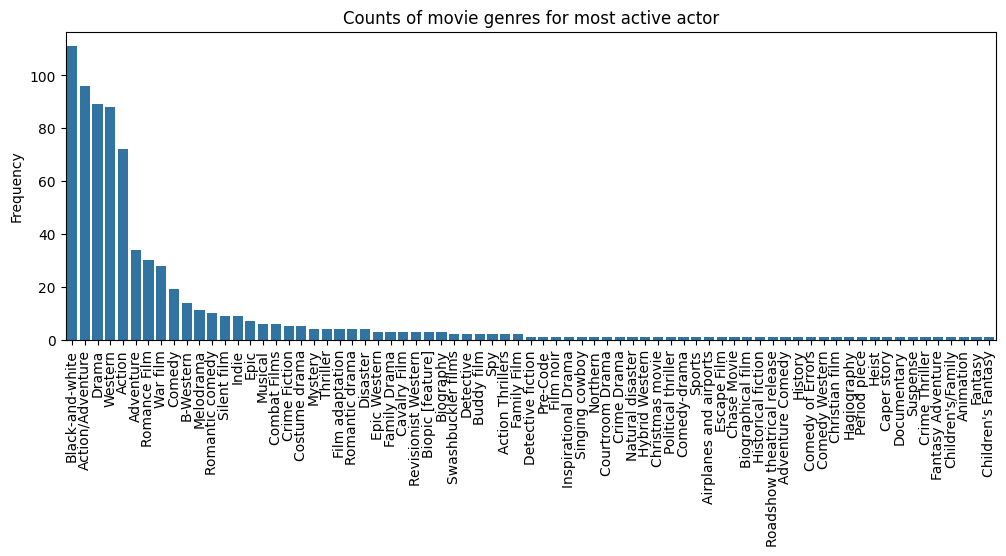

In [18]:
top_actors = movie_genre_per_actor.sort_values("total_movies", ascending=False).copy().head()
actor_1 = top_actors["genres_freq"].iloc[0]

plt.figure(figsize=(12, 4))
plt.title('Counts of movie genres for most active actor')
sns.barplot(x=list(actor_1.keys()), y=list(actor_1.values()))
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

In [19]:
actor_2 = top_actors["genres_freq"].iloc[1]

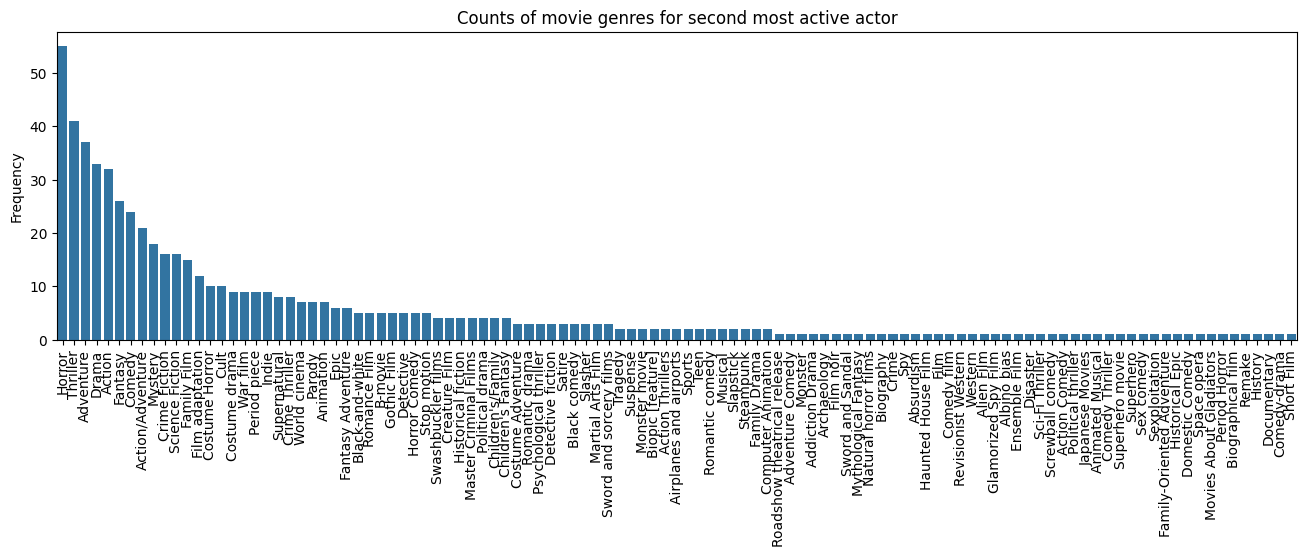

In [20]:
plt.figure(figsize=(16, 4))
plt.title('Counts of movie genres for second most active actor')
sns.barplot(x=list(actor_2.keys()), y=list(actor_2.values()))
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

## Based on runtime minutes <a name="part_3_movie_based_comfort_zones_runtime"></a>

In [21]:
runtime_per_actor = all_data[["freebase_actor_id", "actor_name", "runtimeMinutes"]].copy()

In [22]:
runtime_per_actor = runtime_per_actor[runtime_per_actor["runtimeMinutes"] != "\\N"]

In [23]:
runtime_per_actor = runtime_per_actor.groupby(["freebase_actor_id", "actor_name"]).agg(list).reset_index()

In [24]:
runtime_per_actor["runtimeMinutes"] = runtime_per_actor["runtimeMinutes"].apply(lambda ls: list(map(lambda elem: int(elem), ls)))

In [25]:
runtime_per_actor['len'] = runtime_per_actor['runtimeMinutes'].apply(len)
runtime_per_actor = runtime_per_actor.sort_values(by='len', ascending=False).drop(columns='len')

#### Distribution of some actors

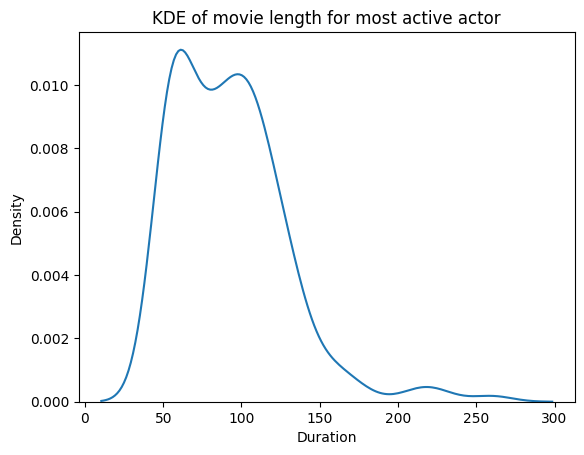

In [26]:
plt.title('KDE of movie length for most active actor')
sns.kdeplot(runtime_per_actor["runtimeMinutes"].iloc[0])
plt.ylabel("Density")
plt.xlabel("Duration")
plt.show()

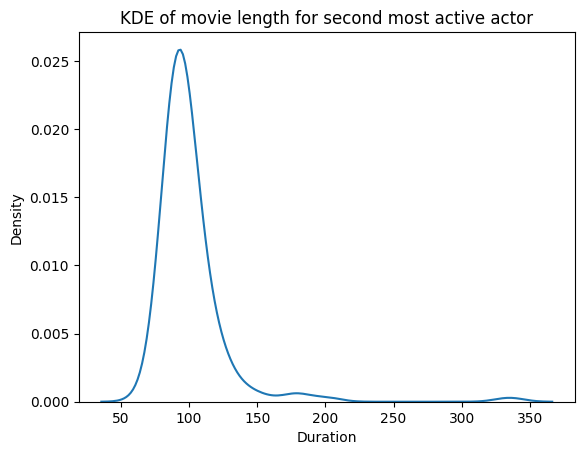

In [27]:
plt.title('KDE of movie length for second most active actor')
sns.kdeplot(runtime_per_actor["runtimeMinutes"].iloc[1])
plt.ylabel("Density")
plt.xlabel("Duration")
plt.show()